# Vision Transformer

## Overview

This notebook is my PyTorch implementation of a Vision Transformer (ViT) model, based on a research paper "[An Image Is Worth 16x16 Words:
Transformers For Image Recognition At Scale](https://arxiv.org/abs/2010.11929)".\
ViTs divide images into a sequence of patches and apply transformer architectures, originally designed for text, to image recognition.

### Models and parameters
|Model|Layers|Embedding size|MLP size|Heads|
|:--:|:---:|:---:|:---:|:---:|
|ViT-T|12|192|768|4|
|ViT-S|12|384|1536|6|
|ViT-S-12|12|384|1536|12

## Install additional dependencies

In [1]:
!pip install torchtyping

  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.9.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.0 which is incompatible.
ydata-profiling 4.9.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


## Imports

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtyping import TensorType

from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

In [4]:
from datetime import date

## Vision Transformer Architecture

### Patch and position embedding

Transformers receive a sequence as input. To feed an image into a transformer, the following steps are followed:
 1. We first use `unfold()` to split the image into non-overlapping `16x16` patches, each flattened into a `1D` vector. For an image of size `224x224`, this results in `n_patches = (224/16) * (224/16) = 196` patches.
 2. Next, a trainable `linear_projection()` layer is used to map each flattened patch into an embedding of size `embed_dim`.
 3. A class token is prepended to the sequence, so the input to the transformer has the shape `(batch_size, n_patches + 1, embed_dim)`, where the additional token is used to aggregate information during classification.
 4. Finally, we add trainable position encodings to each patch and the class token, which provides information about the relative position of each patch in the original image.

In [5]:
class PatchAndPositionEmbedding(nn.Module):
    """
    Combines patch and position embeddings for Vision Transformer (ViT) models.

    Args:
        image_size (int, optional): Input image size (assumed square). Default is 224.
        patch_size (int, optional): Patch size. Default is 16.
        embed_dim (int, optional): Dimensionality of patch embeddings. Default is 192.
        n_channels (int, optional): Number of input channels (e.g., 3 for RGB). Default is 3.
        dropout (float, optional): Dropout rate applied after embeddings. Default is 0.1.

    Attributes:
        n_patches (int): Number of patches in the input image.
        linear_projection (nn.Linear): Linear layer to project flattened patches to the embedding dimension.
        cls_token (nn.Parameter): Learnable class token appended to the patch embeddings.
        pos_embedding (nn.Parameter): Learnable positional embeddings added to the patch and class token embeddings.
        unfold (nn.Unfold): Unfolding layer to extract non-overlapping patches from the image.
        dropout (nn.Dropout): Dropout layer applied to the final patch embeddings.
    """
    
    def __init__(
        self,
        image_size: int = 224,
        patch_size: int = 16,
        embed_dim: int = 192,
        n_channels: int = 3,
        dropout: float = 0.1
    ) -> None:
        """
        Initializes the PatchAndPositionEmbedding module.

        Args:
            image_size (int, optional): Size of the input image (assumed square). Default is 224.
            patch_size (int, optional): Size of each patch to be extracted from the image. Default is 16.
            embed_dim (int, optional): Dimensionality of the patch embeddings. Default is 192.
            n_channels (int, optional): Number of input channels (e.g., 3 for RGB). Default is 3.
            dropout (float, optional): Dropout rate applied to the patch and position embeddings. Default is 0.1.
        """
        
        super(PatchAndPositionEmbedding, self).__init__()
        
        assert image_size % patch_size == 0, f"image_size of {image_size} is not divisible by patch_size of {patch_size}"
        
        self.n_patches = image_size * image_size // patch_size ** 2
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.n_channels = n_channels
        
        self._unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size)
        self._linear_projection = nn.Linear(self.patch_size ** 2 * self.n_channels, self.embed_dim)
        self._cls_token = nn.Parameter(torch.zeros(1, self.embed_dim))
        self._pos_embedding = nn.Parameter(torch.zeros(self.n_patches + 1, self.embed_dim))
        self._dropout = nn.Dropout(dropout)

        
    def forward(self, x: TensorType[torch.float32]) -> TensorType[torch.float32]:
        """
        Forward pass that computes patch embeddings, prepends the class token, and adds positional embeddings.

        Args:
            x (TensorType[torch.float32]): Input tensor of shape (N, C, H, W), where N is the batch size, 
                                           C is the number of channels, and H, W are the height and width of the image.

        Returns:
            TensorType[torch.float32]: Tensor of shape (batch_size, n_patches + 1, embed_dim), where `n_patches + 1` includes 
                                       the class token, and `embed_dim` is the embedding dimension.
        """
        
        # patch embedding
        x = self._unfold(x).transpose(1, 2)
        x = self._linear_projection(x)
        
        # prepending class token
        batch_size = x.shape[0]
        
        cls_tokens = self._cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # positional embedding
        pos_embeddings = self._pos_embedding.expand(batch_size, -1, -1)
        x = x + pos_embeddings
        
        x = self._dropout(x)

        return x

### Vision Transformer (ViT) model

To build a Vision Transformer (ViT) model, we'll use our `PatchAndPositionEmbedding` class along with the `nn.TransformerEncode` module from PyTorch.
1. **Patch and Position Embeddings**: The patch embeddings generated by `PatchAndPositionEmbedding` are fed into 12 layers of Transformer Encoder.
2. **Transformer Encoder Layers**: Each Transformer Encoder layer processes the sequence of patch embeddings, and the output shape is `(n_patches + 1, embed_dim)`, where `n_patches + 1` includes the class token, and `embed_dim` is the embedding dimension.
3. **Output**: After passing through the Transformer Encoder, the output has the shape `(n_patches + 1, n_classes)` (ignoring the batch_size for simplicity). The class token, located in the first position of the sequence, aggregates information from all patches.
4. **MLP Head**:
  - We select the class token and pass it through an MLP Head.
  - The MLP Head consists of a `nn.LayerNorm` layer, followed by a fully connected layers.

In [6]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model for image classification.

    Args:
        image_size (int, optional): Input image size (square). Default is 224.
        patch_size (int, optional): Size of image patches. Default is 16.
        embed_dim (int, optional): Dimensionality of patch embeddings. Default is 192.
        n_layers (int, optional): Number of transformer encoder layers. Default is 12.
        n_heads (int, optional): Number of attention heads. Default is 4.
        mlp_size (int, optional): Size of the MLP layer. Default is 768.
        n_classes (int, optional): Number of output classes. Default is 10.
        n_channels (int, optional): Number of input channels (e.g., 3 for RGB). Default is 3.
        dropout (float, optional): Dropout rate. Default is 0.1.
        batch_first (bool, optional): If True, the batch dimension comes first. Default is False.

    Attributes:
        embedding (PatchAndPositionEmbedding): Patch and position embedding layer.
        transformer_encoder (nn.TransformerEncoder): Transformer encoder with multiple layers.
        MLP (nn.Sequential): Final classification layer with normalization and linear layers.
    """
    
    def __init__(
        self,
        image_size: int = 224,
        patch_size: int = 16,
        embed_dim: int = 192,
        n_layers: int = 12,
        n_heads: int = 4,
        mlp_size: int = 768,
        n_classes: int = 10,
        n_channels: int = 3,
        dropout: float = 0.1,
        batch_first: bool = False
    ) -> None:
        """
        Initializes the VisionTransformer model.

        Args:
            image_size (int, optional): Size of the input image. Default is 224.
            patch_size (int, optional): Size of image patches. Default is 16.
            embed_dim (int, optional): Dimensionality of patch embeddings. Default is 192.
            n_layers (int, optional): Number of transformer encoder layers. Default is 12.
            n_heads (int, optional): Number of attention heads. Default is 4.
            mlp_size (int, optional): Size of the MLP layer. Default is 768.
            n_classes (int, optional): Number of output classes. Default is 10.
            n_channels (int, optional): Number of input channels. Default is 3.
            dropout (float, optional): Dropout rate. Default is 0.1.
            batch_first (bool, optional): If True, batch dimension comes first. Default is False.
        """
        
        super(VisionTransformer, self).__init__()
        
        self._batch_first = batch_first
        
        self._embedding = PatchAndPositionEmbedding(image_size, patch_size, embed_dim, n_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dim_feedforward=mlp_size,
            dropout=dropout,
            activation='gelu',
            batch_first=self._batch_first
        )
        self._transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        self._MLP = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, n_classes)
        )
        
        self._init_weights()
                
    def _init_weights(self):
        """
        Initializes the weights of the model, including the class token, positional embedding, 
        and the linear projection layer.
        """
        
        nn.init.trunc_normal_(self._embedding._cls_token, std=0.02)
        nn.init.trunc_normal_(self._embedding._pos_embedding, std=0.02)
        nn.init.xavier_normal_(self._embedding._linear_projection.weight)
        nn.init.zeros_(self._embedding._linear_projection.bias)
    
                    
    def forward(self, x: TensorType[torch.float32]) -> TensorType[torch.float32]:
        """
        Forward pass of the VisionTransformer model.

        Args:
            x (TensorType[torch.float32]): Input image tensor of shape (C, H, W), where C is the number of channels, 
                                           and H, W are the height and width of the image.

        Returns:
            TensorType[torch.float32]: Output logits of shape (batch_size, n_classes), representing the class scores.
        """
        
        x = self._embedding(x)
        
        if not self._batch_first: 
            x = x.transpose(0, 1)
        
        x = self._transformer_encoder(x)
        
        cls_token = x[:, 0] if self._batch_first else x[0]
        
        logits = self._MLP(cls_token)
        
        return logits

### Trainer class

To train our model, I’ve implemented a Trainer class with the following features:
1. **Multi-GPU Support**: The class utilizes `nn.DataParallel` for multi-GPU training. This allows the model to be trained on multiple GPUs in parallel. Note that `torch.nn.parallel.DistributedDataParallel` isn't used here because it requires multiprocessing, which doesn’t work well in Jupyter environments.
2. **Loss Function**: The class employs `nn.CrossEntropyLoss`, a suitable loss function for classification tasks, to compute the loss during training.
3. **Training Process**:
  - The model is trained for a user-specified number of epochs.
  - After each epoch, the model is evaluated to track performance over time.
4. **Model Saving**: Users can provide a path to save the trained model once the training process is complete.
5. **Statistics Plotting**: Users can plot the model's training loss, validation loss, and validation accuracy.

In [7]:
class Trainer():
    """
    Trainer class for managing the training and testing of a PyTorch model.

    Args:
        model (nn.Module): The neural network model to be trained.
        dataloaders (tuple[DataLoader, DataLoader]): A tuple containing the training and testing DataLoaders.
        optimizer (optim.Optimizer): The optimizer used for training the model.
        device (str | torch.device): The device (e.g., 'cpu', 'cuda') to which the model and data should be moved.
        log_interval (int, optional): The interval (in batches) for logging training loss. Default is 10.

    Attributes:
        device (str | torch.device): The device used for training.
        _model (nn.DataParallel): The model wrapped in a DataParallel module for multi-GPU training.
        _train_dataloader (DataLoader): The DataLoader for the training dataset.
        _test_dataloader (DataLoader): The DataLoader for the testing dataset.
        _optimizer (optim.Optimizer): The optimizer used for updating the model weights.
        _loss_fn (nn.CrossEntropyLoss): The loss function used for training.
        _softmax (nn.Softmax): The softmax layer for converting logits to probabilities.
        _train_loss (list[float]): A list storing the training loss for each epoch.
        _test_loss (list[float]): A list storing the test loss for each epoch.
        _log_interval (int): The interval (in batches) for logging training loss. Default is 10.
        _test_accuracy (list[float]): A list storing the test accuracy for each epoch.
    """
    
    def __init__(
        self,
        model: nn.Module,
        dataloaders: tuple[DataLoader, DataLoader],
        optimizer: optim.Optimizer,
        device: str | torch.device,
        log_interval: int = 10
    ) -> None:
        """
        Initializes the Trainer with the given model, dataloaders, optimizer, and device.

        Args:
            model (nn.Module): The neural network model to be trained.
            dataloaders (tuple[DataLoader, DataLoader]): A tuple containing the training and testing DataLoaders.
            optimizer (optim.Optimizer): The optimizer used for training the model.
            device (str | torch.device): The device (e.g., 'cpu', 'cuda') to which the model and data should be moved.
            log_interval (int, optional): The interval (in batches) for logging training loss. Default is 10.
        """
        
        self.device = device
        self._model = nn.DataParallel(model.to(self.device))
        self._train_dataloader, self._test_dataloader = dataloaders
        self._optimizer = optimizer
        self._loss_fn = nn.CrossEntropyLoss()
        self._softmax = nn.Softmax(dim=1)
        
        self._log_interval = log_interval
        self._train_loss = []
        self._test_loss = []
        self._test_accuracy = []
        
    def _train_epoch(self) -> None:
        """
        Executes one epoch of training on the training dataset.

        This method iterates over the training DataLoader, computes the loss, 
        performs backpropagation, and updates the model weights. It logs the 
        loss every 'log_interval' batches and appends the average loss for the 
        epoch to the training loss list.
        """
        
        avg_loss = 0.0
        avg_epoch_loss = 0.0
        n_batches = len(self._train_dataloader)
        n_samples = len(self._train_dataloader.dataset)

        self._model.train()
        for batch_index, (X, y) in enumerate(self._train_dataloader, 1):
            X, y = X.to(self.device), y.to(self.device)

            prediction = self._model(X)
            loss = self._loss_fn(prediction, y)

            avg_loss += loss.item()
            avg_epoch_loss += loss.item()

            self._optimizer.zero_grad()
            loss.backward()
            self._optimizer.step()
            
            

            if batch_index % self._log_interval == 0:
                loss = loss.item()
                current_sample = batch_index * len(X)

                print(
                    f'Current loss: {loss:.5f}, ' \
                    f'Average loss across 10 batches: {avg_loss / self._log_interval:.5f} ' \
                    f'[{current_sample} / {n_samples}]'
                )
                avg_loss = 0.0
                
        self._train_loss.append(avg_epoch_loss / n_batches)
                
    def _test_epoch(self) -> None:
        """
        Evaluates the model on the testing dataset.

        This method sets the model to evaluation mode, computes the average test loss, 
        and calculates the accuracy over the entire test set. The average loss and 
        accuracy are appended to the respective lists for plotting and analysis.
        """
        
        self._model.eval()
        
        avg_test_loss = 0.0
        n_correct = 0
        n_batches = len(self._test_dataloader)
        n_samples = len(self._test_dataloader.dataset)

        for X, y in self._test_dataloader:
            X, y = X.to(self.device), y.to(self.device)

            with torch.no_grad():
                prediction = self._model(X)

                loss = self._loss_fn(prediction, y)
                avg_test_loss += loss.item()

                prediction = self._softmax(prediction)
                n_correct += (torch.argmax(prediction, dim=1) == y).sum().item()
                
        avg_test_loss /= n_batches
        accuracy = n_correct / n_samples * 100

        print(
            f'Average test loss: {avg_test_loss:.5f}, ' \
            f'Accuracy: {accuracy:.2f}%'
        )
        
        self._test_loss.append(avg_test_loss)
        self._test_accuracy.append(accuracy)

        
    def train(self, n_epochs: int, path: str | None, plot: bool = True) -> None:
        """
        Trains the model for a specified number of epochs.

        This method trains the model for the given number of epochs, evaluates 
        it after each epoch, and optionally saves the model to a file. It can 
        also plot the training statistics after training if requested.

        Args:
            n_epochs (int): The number of epochs to train the model.
            path (str | None): The file path to save the model after training. If None, the model is not saved.
            plot (bool, optional): Whether to plot the training statistics after training. Default is True.
        """
        
        for epoch in range(n_epochs):
            print(f"|--------------------------{epoch + 1}/{n_epochs}--------------------------|")
            self._train_epoch()
            self._test_epoch()
            
        if path:
            self.save_model(path)
            
        if plot:
            self.plot_statistics()
            
            
    def save_model(self, path: str) -> None:
        """
        Saves the model state dictionary to the specified file path.

        Args:
            path (str): The file path where the model will be saved.
        """
        
        state = self._model.module.state_dict()
        torch.save(state, path)
        print(f'Model saved in: {path}')
        
    
    def plot_statistics(self) -> None:
        """
        Plots the training and testing loss over epochs, as well as test accuracy.

        This method creates two plots:
        1. A line plot showing both the training and testing loss over each epoch.
        2. A line plot showing the testing accuracy over each epoch.

        These plots provide insight into the model's performance during training.

        Attributes used:
            _train_loss (list[float]): List of average training loss values for each epoch.
            _test_loss (list[float]): List of average testing loss values for each epoch.
            _test_accuracy (list[float]): List of testing accuracy values for each epoch.
        """
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle("Train Statstics")
                
        #plot train and test loss
        line1, = ax1.plot(self._train_loss, label="train loss")
        line2, = ax1.plot(self._test_loss, label="test loss")
        ax1.legend(handles=[line1, line2])
        ax1.set_title("Train/Test Loss")
        ax1.set_ylabel("Loss")
        ax1.set_xlabel("Epoch")

        
        #plot accuracy
        ax2.plot(self._test_accuracy)
        ax2.set_title("Test Accuracy")
        ax2.set_ylabel("Accuracy (%)")
        ax2.set_xlabel("Epoch")
        
        plt.show()
        

## Preparing the data

### Defining Transforms

We define transformations for both the training and testing datasets to ensure consistency and prepare the images for input into the model:
1. **Resizing**: All images are resized to `224x224` pixels to match the input size required by the Vision Transformer (ViT) model.
2. **Training Data Augmentation**: For the training data, we apply a 50% chance of a random vertical flip to introduce data augmentation and increase model robustness to variations.
3. **Common Transforms**:
  - Both the training and testing images are converted from `PIL` Image objects into tensors.
  - The tensors are cast to `torch.float32` to ensure compatibility with the model.
  - Finally, pixel values are scaled to the range `[0, 1]` for both training and testing datasets.

In [8]:
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomVerticalFlip(p=0.5),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

### Data Loading

We load the training and testing data using PyTorch's `ImageFolder`, which is suitable because each class of images is organized into its own directory. We pass the paths to the train and test directories along with the previously defined transformations.

The dataset used to train the model is the [Packed Fruits and Vegetables Recognition Benchmark](https://www.kaggle.com/datasets/sergeynesteruk/packed-fruits-and-vegetables-recognition-benchmark) dataset.

In [9]:
train_dataset = ImageFolder(
    root='/kaggle/input/packed-fruits-and-vegetables-recognition-benchmark/train/train',
    transform=train_transforms
)
test_dataset = ImageFolder(
    root='/kaggle/input/packed-fruits-and-vegetables-recognition-benchmark/test/test',
    transform=test_transforms
)

In [10]:
len(train_dataset), len(test_dataset)

(81489, 21951)

### Preparing the dataloaders

We define a simple `get_dataloaders()` function to create and return PyTorch `DataLoader`s for both the training and testing datasets. The function sets the following parameters:

1. **Batch Size**: Set to `256` for efficient batch processing.
2. **Number of Workers**: Set to `4` to parallelize data loading and speed up the process.
3. **Memory Pinning**: `pin_memory=True` is enabled to improve performance when transferring data to the GPU.
4. **Shuffling**: For the training data, `shuffle=True` is used to randomize the data at the start of each epoch, ensuring better generalization.

The function returns a tuple containing the train and test DataLoaders.

In [11]:
def get_dataloaders(batch_size: int = 256, shuffle_test: bool = False) -> tuple[DataLoader, DataLoader]:
    """
    Returns the DataLoader objects for the training and testing datasets.

    Args:
        batch_size (int, optional): The number of samples per batch to load. Default is 256.
        shuffle_test (bool, optional): If True, shuffles the test dataset. Default is False.

    Returns:
        tuple[DataLoader, DataLoader]: A tuple containing:
            - DataLoader for the training dataset (with shuffling enabled).
            - DataLoader for the testing dataset (with optional shuffling based on 'shuffle_test').

    The DataLoader for the training set has shuffle enabled, and both DataLoaders 
    use pin_memory for faster data transfer to GPU and 4 worker threads for loading the data.
    """
    
    return (
        DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=4,
        ),
        DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=shuffle_test,
            pin_memory=True,
            num_workers=4,
        )
    )

In [12]:
X, y = test_dataset[0]
X.shape

torch.Size([3, 224, 224])

Here we can see the first `5` classes from our dataset:

In [13]:
idx_to_class_train = train_dataset.find_classes(train_dataset.root)[0]
idx_to_class_test = test_dataset.find_classes(test_dataset.root)[0]
idx_to_class_train[:5]

['apple_fuji',
 'apple_golden',
 'apple_granny',
 'apple_ligol',
 'apple_red_delicious']

### Patch embedding visualization

The following code demonstrates how patch embedding works by visualizing the process. On the left, we display the original image, and on the right, the image is divided into `16x16` patches, showing how the Vision Transformer (ViT) splits the input into smaller, fixed-size sections for further processing. This visualization helps illustrate how ViT operates on image patches to capture visual features.

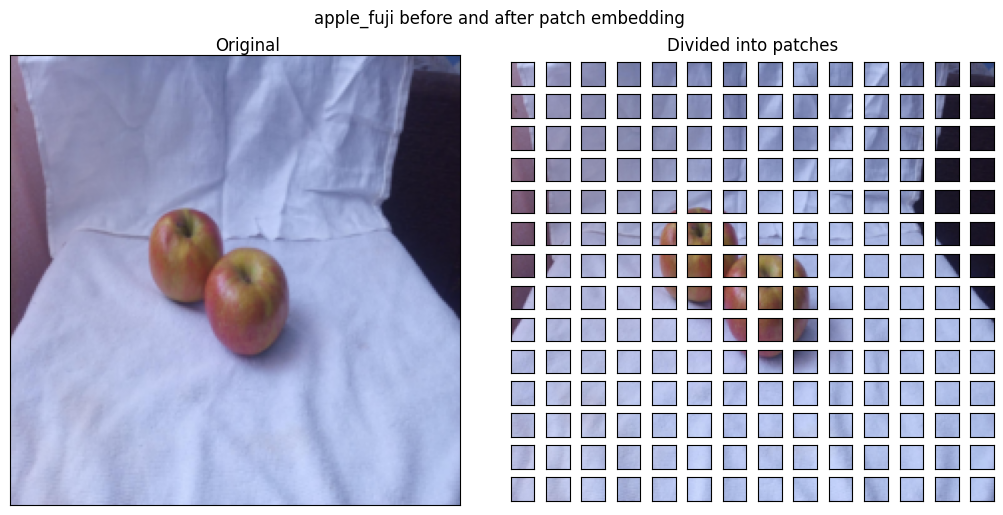

In [14]:
fig = plt.figure(layout='constrained', figsize=(10, 5))
subfig1, subfig2 = fig.subfigures(1, 2)

# display original image
ax = subfig1.add_axes((0, 0, 0.95, 0.95))
ax.imshow(X.permute(1, 2, 0))
ax.set_xticks([])
ax.set_yticks([])
subfig1.suptitle('Original')

# get patches
patches = PatchAndPositionEmbedding()._unfold(X).transpose(0, 1)
n_patches = 224 // 16

# display patches
axs = subfig2.subplots(nrows=n_patches, ncols=n_patches).flatten()
for i, patch in enumerate(patches):
    axs[i].imshow(patch.reshape(3, 16, 16).permute(1, 2, 0))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

subfig2.suptitle('Divided into patches')

fig.suptitle(f"{idx_to_class_test[y]} before and after patch embedding")

plt.show()

## Training the ViT

### Hyperparameters

Finally, it's time to train the model. We begin by creating an instance of the `VisionTransformer` class, configuring it with the desired parameters. We set the following training settings:

1. **Number of Epochs**: Set to `10`.
2. **Learning Rate**: Set to `8e-5`.
3. **Batch Size**: Set to `256`.
4. **Optimizer**: We use the AdamW optimizer, which is well-suited for transformer models.
5. **Weight Decay**: A weight decay of `0.1`, as mentioned in the original Vision Transformer paper, is applied.

In [15]:
ViT = VisionTransformer(embed_dim=384, n_heads=6, mlp_size=1536, batch_first=True, n_classes=len(idx_to_class_train))

In [16]:
N_EPOCHS = 10
LEARNING_RATE = 8e-5
WEIGHT_DECAY = 0.1

optimizer = optim.AdamW(ViT.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [ ]:
device = "cuda"
trainer = Trainer(
    model=ViT,
    dataloaders=get_dataloaders(),
    optimizer=optimizer,
    device=device
)
trainer.train(n_epochs=N_EPOCHS, path=f'ViT-Sd-{date.today().isoformat()}.pth')

## Evaluating Models Performance

Now let's compare the models using the `get_models_accuracy()` function. This function takes a dictionary of models, evaluates each on the test dataset using cross-entropy loss, and returns a dictionary containing the average loss (computed across the entire dataset) and accuracy for each model.

In [ ]:
def get_models_accuracy(
    dataloaders: tuple[DataLoader, DataLoader],
    models: dict[str, nn.Module],
    device: str | torch.device
) -> dict[str, dict[str, float]]:
    
    """
    Evaluates the accuracy and average test loss of multiple models on a test dataset.

    Args:
        dataloaders (tuple[DataLoader, DataLoader]): A tuple containing the training and testing DataLoaders. 
                                                     Only the testing DataLoader is used.
        models (dict[str, nn.Module]): A dictionary where keys are model names (str) and values are PyTorch models (nn.Module).
        device (str | torch.device): The device on which the models will be evaluated (e.g., 'cuda' or torch.device object).

    Returns:
        dict[str, dict[str, float]]: A dictionary where each key is a model name (str) and the corresponding value 
                                     is another dictionary with the model's average test loss ('loss') and accuracy ('accuracy').

    The function computes the loss and accuracy for each model by iterating over the test dataset, and stores the results in a dictionary.
    """
    
    results: dict[str, dict[str, float]] = {}
    
    _, test_dataloader = dataloaders
    
    loss_fn = nn.CrossEntropyLoss()
    softmax = nn.Softmax(dim=1)
    
    with torch.no_grad():
        for model_name in models.keys():
            
            model = nn.DataParallel(models[model_name].to(device))
            model.eval()
        
            avg_test_loss = 0.0
            n_correct = 0
            n_samples = len(test_dataloader.dataset)
            n_batches = len(test_dataloader)

            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)

                prediction = model(X)

                loss = loss_fn(prediction, y)
                avg_test_loss += loss.item()

                prediction = softmax(prediction)
                n_correct += (torch.argmax(prediction, dim=1) == y).sum().item()

            results[model_name] = {"loss": avg_test_loss / n_batches, "accuracy": n_correct / n_samples * 100}
    
    return results
    

### Loading the Models

Before comparing the models, we need to load their pre-trained weights from the appropriate files using PyTorch's `load_state_dict()`.

In [15]:
ViT_T = VisionTransformer(batch_first=True, n_classes=len(idx_to_class_train))
ViT_S = VisionTransformer(embed_dim=384, n_heads=6, mlp_size=1536, batch_first=True, n_classes=len(idx_to_class_train))
ViT_S_12 = VisionTransformer(embed_dim=384, n_heads=12, mlp_size=1536, batch_first=True, n_classes=len(idx_to_class_train))

In [20]:
ViT_T.load_state_dict(torch.load("/kaggle/input/vision-transformer/pytorch/vit-t/1/ViT-T-2024-10-09.pth", weights_only=True, map_location=torch.device("cpu")))
ViT_S.load_state_dict(torch.load("/kaggle/input/vision-transformer/pytorch/vit-s/1/ViT-S-2024-10-09.pth", weights_only=True, map_location=torch.device("cpu")))
ViT_S_12.load_state_dict(torch.load("/kaggle/input/vision-transformer/pytorch/vit-s-12/1/ViT-S-12-2024-10-08.pth", weights_only=True, map_location=torch.device("cpu")))

<All keys matched successfully>

### Results

With the pre-trained weights loaded, we can now evaluate the models on the test dataset. Below are the results:

In [ ]:
models = {"ViT-T": ViT_T, "ViT-S": ViT_S, "ViT-S-12": ViT_S_12}
results = get_models_accuracy(get_dataloaders(), models=models, device="cuda")

In [ ]:
for model_name, metrics in results.items():
    print(f"{model_name} - Loss: {metrics['loss']:.5f}, Accuracy: {metrics['accuracy']:.2f}%")

## Visualizing Attention

To understand which parts of an image contribute the most to a model's decision-making, we can generate an attention map. The steps are as follows:
1. Extract the attention weights from each multihead attention layer and compute the average across the heads.
2. Calculate the attention rollout using the following formula:
$$A^l_{rollout} = (A^l + I)A^{l-1}_{rollout}, \text{for}\,i > 1\\
A^1_{rollout} = A^1 + I$$
where:
  - $A^l$ represents the average attention weights across heads for the $l$-th layer
  - $I$ is the identity matrix, used to account for residual connections
3. Select the first column of the final attention rollout, which estimates the self-attention weights of the CLS token for all tokens in the sequence, excluding the first row (the attention of the CLS token). This serves as the mask we'll apply to our image.
4. Normalize the mask by dividing each element by its maximum value, then resize it to match the image dimensions.
5. Apply the mask to the original image to generate an attention-highlighted output.

In [151]:
def get_attention_map(model: nn.Module, image: TensorType[torch.float32]) -> np.ndarray:
    """
    Computes the attention map for a given image using the attention layers of a Vision Transformer (ViT) model.

    This function calculates the attention rollout, which aggregates the attention weights across all layers 
    to generate a heatmap representing the importance of different image regions.

    Args:
        model (nn.Module): The Vision Transformer (ViT) model containing a transformer encoder.
        image (TensorType[torch.float32]): The input image tensor of shape (C, H, W), where C is the number of channels, 
                                           and H and W are the height and width of the image, respectively.

    Returns:
        np.ndarray: An attention map overlayed on the input image, resized to match the original image dimensions 
                    and with the same number of channels as the input image.

    Process:
        1. Extracts the transformer encoder layers and embedding from the model.
        2. Computes attention weights for each layer of the transformer using the self-attention mechanism.
        3. Calculates the attention rollout, incorporating skip connections (identity matrix) to account 
           for the layer-wise impact of attention.
        4. Generates an attention mask, which is resized to match the input image size.
        5. Applies the mask to the original image to produce an attention-highlighted output.

    Returns an attention-weighted image, visualizing which parts of the input image contributed most 
    to the model's decision-making.
    """
    
    image_size = image.shape[1]
    encoder_layers = model._transformer_encoder.layers
    embedding = model._embedding
    attention_weights = []

    for layer in encoder_layers:
        X_embeded = embedding(X.unsqueeze(0))
        _, attention_output_weights = layer.self_attn(X_embeded, X_embeded, X_embeded)
        attention_weights.append(attention_output_weights.squeeze())
        
    A_1 = attention_weights[0]
    I = torch.eye(len(A_1))
    A_1_rollout = A_1 + I
    
    A_l_prev_rollout = A_1_rollout
    for i in range(1, len(attention_weights)):
        A = attention_weights[i]
        A_l_rollout = (A + I) @ A_l_prev_rollout
        A_l_prev_rollout = A_l_rollout
        
    mask_size = int(np.sqrt(A_1.shape[0]))
    mask = A_l_rollout[0, 1:].reshape(mask_size, mask_size)
    
    mask = mask / mask.max()
    
    return (cv2.resize(mask.detach().numpy(), (image_size, image_size)) * X.numpy()).transpose(1, 2, 0)

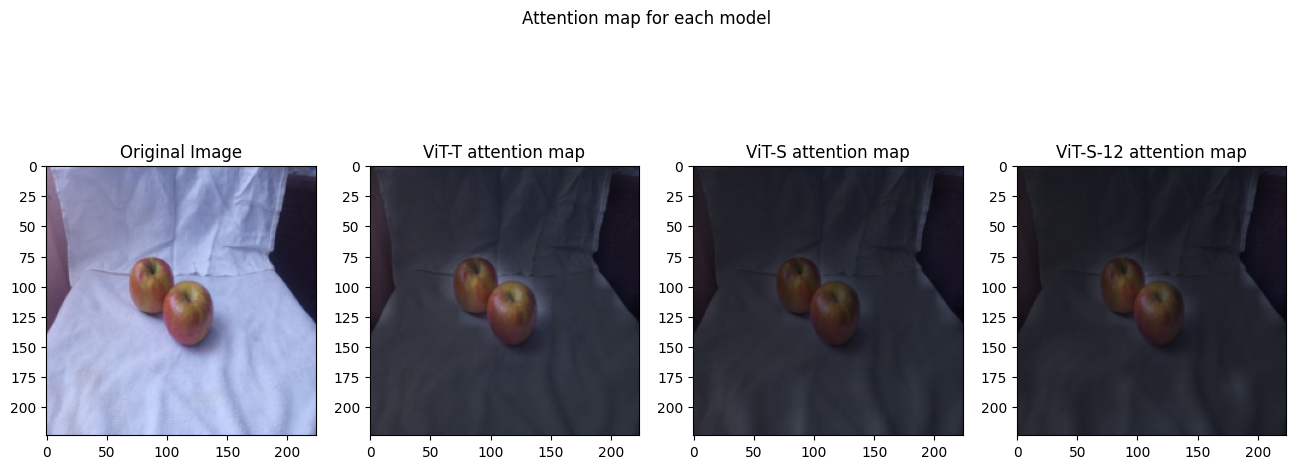

In [152]:
X, y = test_dataset[0]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 6))

fig.suptitle("Attention map for each model")

ax1.set_title("Original Image")
ax1.imshow(X.permute(1, 2, 0))

ax2.set_title("ViT-T attention map")
ax2.imshow(get_attention_map(ViT_T, X))

ax3.set_title("ViT-S attention map")
ax3.imshow(get_attention_map(ViT_S, X))

ax4.set_title("ViT-S-12 attention map")
ax4.imshow(get_attention_map(ViT_S_12, X))

plt.show()